# infrastructure-clustering

The procedure of supernode clustering with respect to infrastructure features.

Requires:
1. `data/supernodes/supernodes.json`
2. `data/features/infrastructure_features.json`

Produces:
1. `data/clustering/infrastructure_clusters.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from myutils.json import save_json

from config import supernodes_fpath, infrastructure_features_fpath, infrastructure_clusters_fpath

plt.style.use('seaborn-whitegrid')

In [3]:
features = pd.read_json(infrastructure_features_fpath).set_index('id')

total = features['total']
features = features.drop(columns=['total'])

mask = (total <= 10)
infrastructureless = features[mask].copy()
features = features[~mask].copy()

features.head(2)

,residential,shop,restaurant,service,medicine,education_research,tourism,sport,car_related,company,administrative,supermarket,hotel_business,industrial,bank_and_money,printing_and_books,post_office,religion,business_center_or_mall_or_marketplace,theatre_cinema
id,,,,,,,,,,,,,,,,,,,,
0,0.234609,0.247920,0.123128,0.071547,0.076539,0.034942,0.023295,0.054908,0.008319,0.008319,0.013311,0.021631,0.004992,0.003328,0.044925,0.021631,0.006656,0.000000,0.000000,0.0
1,0.185309,0.190317,0.180301,0.070117,0.085142,0.055092,0.068447,0.021703,0.010017,0.015025,0.030050,0.010017,0.021703,0.010017,0.011686,0.015025,0.006678,0.011686,0.001669,0.0


In [4]:
infrastructureless.shape

(540, 20)

In [5]:
features.isna().any().any()

False

In [6]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


In [7]:
coords = supernodes[['lon', 'lat']].values

infrastructureless_coords = coords[mask].copy()
coords = coords[~mask].copy()

coords

array([[30.3224152 , 59.85170995],
       [30.28793738, 59.95020979],
       [30.35401882, 59.95671589],
       ...,
       [30.3595223 , 59.9445053 ],
       [30.2344264 , 59.94853172],
       [30.21190075, 59.97198015]])

## Clustering

In [8]:
def plot_inertia(array: np.ndarray):
    ks = np.arange(2, 21)
    inertia = []

    for k in tqdm(ks):
        kmeans = KMeans(n_clusters=k).fit(array)
        inertia.append(kmeans.inertia_)

    plt.plot(ks, inertia, lw=2, zorder=5)
    
    plt.xticks(ks, ks)
    plt.grid(ls='dotted')
    plt.title('KMeans inertia')
    
    plt.show()
    plt.close()

In [9]:
def plot_clusters(clusters: np.ndarray, tsne: np.ndarray, coords: np.ndarray):
    fig, axes = plt.subplots(ncols=2)
    fig.set_size_inches(12, 6)
    
    arrays = [tsne, coords]
    titles = ['tSNE', 'coordinates']
    
    for ax, array, title in zip(axes, arrays, titles):
        for i in np.unique(clusters):
            subarray = array[clusters == i]
            ax.scatter(*array[clusters == i].T, color=f'C{i}', marker='.', s=5, label=f'cl. {i} (size {subarray.shape[0]})')
            
        ax.axis('off')
        ax.set_title(title)
            
    axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))

In [10]:
def plot_separate_clusters(
        features: pd.DataFrame,
        clusters: np.ndarray,
):
    nclusters = np.unique(clusters).size
    
    ncols = 3
    nrows = nclusters // ncols + int(nclusters % ncols > 0)
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
    fig.set_size_inches(4 * ncols, 4 * nrows)
    axes = axes.flatten()
    
    for i, ax in zip(np.unique(clusters), axes):
        cluster = features[clusters == i]
        cluster_mean = cluster.mean(axis=0)
        
        for _, row in cluster.iterrows():
            ax.plot(row, c=f'C{i}', lw=0.1)
            
        ax.plot(cluster_mean, c='k', ls='dashed', lw=1, zorder=2)
        
        ax.tick_params(labelbottom=False)
        ax.set_ylim(top=features.max().max())
        
    for i in range(nclusters, len(axes)):
        axes[i].axis('off')

In [11]:
def get_cluster_feature_significance(
        features: pd.DataFrame,
        clusters: np.ndarray,
) -> pd.DataFrame:
    mean = features.mean(axis=0)
    std = features.std(axis=0)
    
    feature_significance = {}
    
    for i in np.unique(clusters):
        cluster = features[clusters == i]
        cluster_size = cluster.shape[0]
        cluster_mean = cluster.mean(axis=0)

        cluster_feature_significance = (cluster_mean - mean) / std * np.sqrt(cluster_size)
        feature_significance[i] = cluster_feature_significance

    feature_significance = pd.DataFrame(feature_significance).T
    
    return feature_significance

In [12]:
def plot_cluster_features(
        features: pd.DataFrame,
        clusters: np.ndarray,
):
    mean = features.mean(axis=0)
    std = features.std(axis=0, ddof=1)
    
    fig, (ax1, ax2) = plt.subplots(nrows=2)
    fig.set_size_inches(8, 6)
    fig.subplots_adjust(hspace=0.05)
    
    for i in np.unique(clusters):
        cluster = features[clusters == i]
        
        cluster_size = cluster.shape[0]
        cluster_mean = cluster.mean(axis=0)

        ax1.plot(cluster_mean.values, lw=1, c=f'C{i}', marker='.', markersize=3,
                 label=f'cl. {i} (size {cluster_size})')
        
        cluster_feature_significance = (cluster_mean - mean) / std * np.sqrt(cluster_size)
        ax2.plot(cluster_feature_significance.values, lw=1, marker='.', markersize=3)
        
    ax1.plot(mean, c='k', lw=1, ls='dashed', label='mean')
    # ax1.fill_between(mean.index, mean - 2 * std, mean + 2 * std, color='k', alpha=0.1)
    ax2.plot(mean * 0, lw=1, c='k', ls='dashed')
    
    columns = pd.Series(features.columns)
    
    for ax in [ax1, ax2]:
        ax.set_xticks(columns.index)
        ax.set_xticklabels(columns.values)
        ax.tick_params(axis='x', rotation=90)
       
    ax1.tick_params(bottom=False, labelbottom=False, labeltop=True)
    
    ax1.set_ylabel('Features')
    ax2.set_ylabel('Feature significance')

    ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0))

In [13]:
def plot_total_by_cluster(
    total: pd.Series,
    clusters: np.ndarray,
    log: bool = True,
):
    for i in np.unique(clusters):
        cluster_total = total[clusters == i]
        
        ox = np.linspace(cluster_total.min(), cluster_total.max(), 500)
        oy = stats.gaussian_kde(cluster_total)(ox)
        plt.plot(ox, oy, c=f'C{i}')

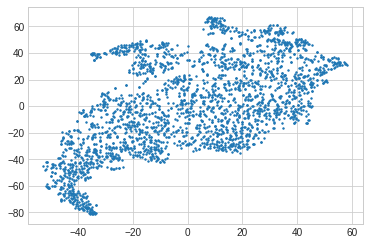

In [14]:
tsne = TSNE(random_state=0).fit_transform(features.values)

plt.scatter(*tsne.T, s=2)

100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


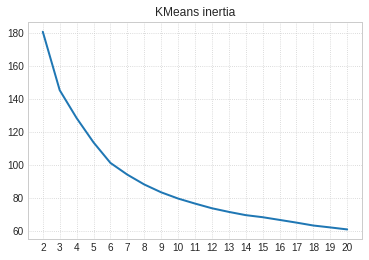

In [15]:
plot_inertia(features)

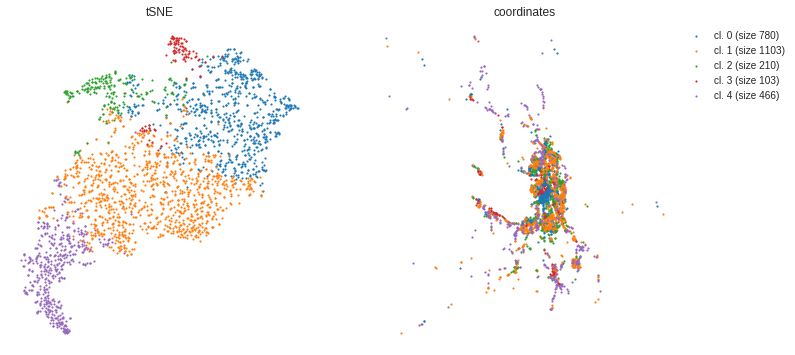

In [16]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(features)
clusters = kmeans.predict(features)

plot_clusters(clusters, tsne, coords)

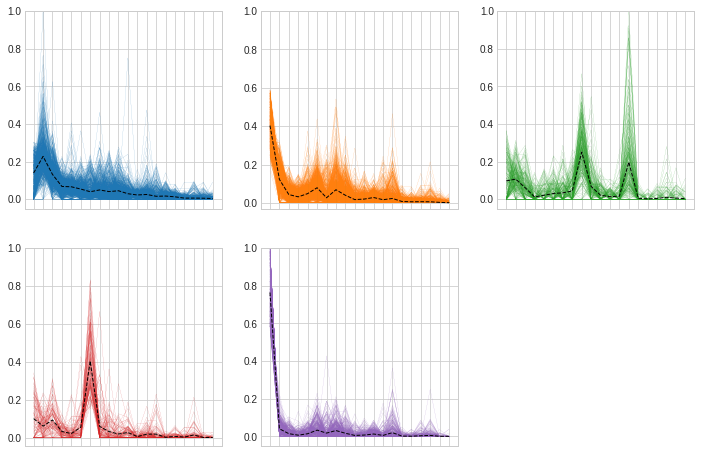

In [17]:
plot_separate_clusters(
    features=features,
    clusters=clusters,
)

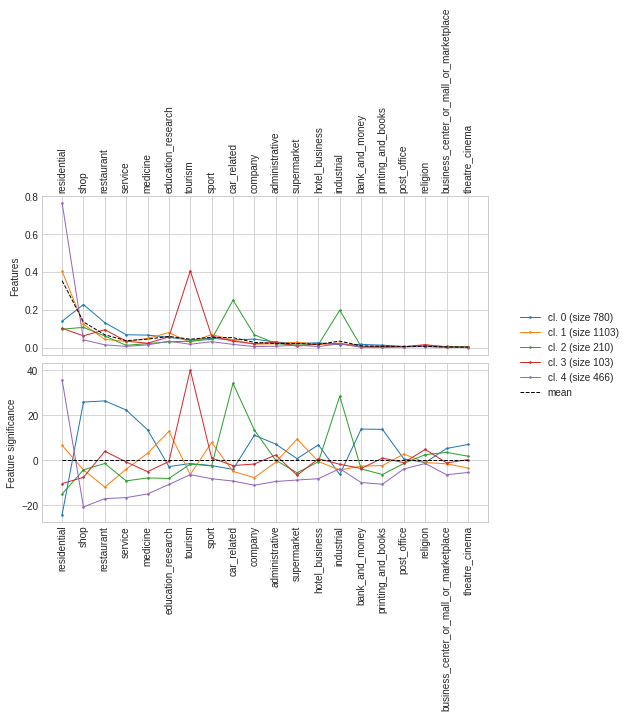

In [18]:
plot_cluster_features(
    features=features,
    clusters=clusters,
)

The 5 clusters can be interpreted as follows:

* Mainly tourist areas: tourism, restaurants, not much else (~103)
* "Good" residential areas: housing with schools, hospitals, shops nearby (~1105)
* "Bad" residential areas: housing with pretty much nothing nearby (~465)
* Industrial areas, fuel stations, other car-related stuff (~206)
* City center: not much housing, mainly shops, restaurants, services, banks etc. (~783)

Additionally, we have a separate "cluster" of supernodes with small number (less than 10) of infrastructure objects around (~540).

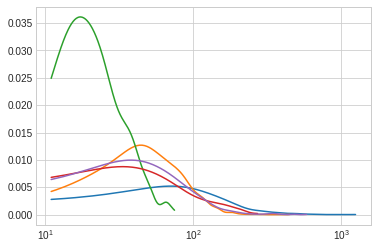

In [19]:
plot_total_by_cluster(total[~mask], clusters)

# plt.xlim(0, 100)
plt.xscale('log')

"Industrial" stops on average have the smallest number (less than 20) of infrastructure objects around them. Tourism-related and "bad residential" stops follow with about 35-45 objects, "good residential" stops get around 40-50 objects, and the largest number of objects connects to the central stops (90-110). Note that the number of objects around a stop was not used in clustering (only fractions of various kinds of objects), so such correspondence seems reasonable.

In [20]:
clusters = pd.DataFrame({
    'id': features.index.tolist() + infrastructureless.index.tolist(),
    'cluster': np.concatenate([clusters, -1 * np.ones(infrastructureless.shape[0], dtype=int)]),
})

clusters

,id,cluster
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
...,...,...
3197,3160,-1
3198,3173,-1
3199,3178,-1
3200,3179,-1


__Warning!__ The following cluster numbering can differ if you run the code above on a different machine.

In [21]:
named_clusters = {
    0: 'city_center',
    1: 'residential_area_good',
    2: 'industrial_area',
    3: 'tourism_area',
    4: 'residential_area_bad',
    -1: 'infrastructureless_area',
}

clusters['cluster_name'] = clusters['cluster'].apply(named_clusters.get)

clusters

,id,cluster,cluster_name
0,0,0,city_center
1,1,0,city_center
2,2,0,city_center
3,3,1,residential_area_good
4,4,0,city_center
...,...,...,...
3197,3160,-1,infrastructureless_area
3198,3173,-1,infrastructureless_area
3199,3178,-1,infrastructureless_area
3200,3179,-1,infrastructureless_area


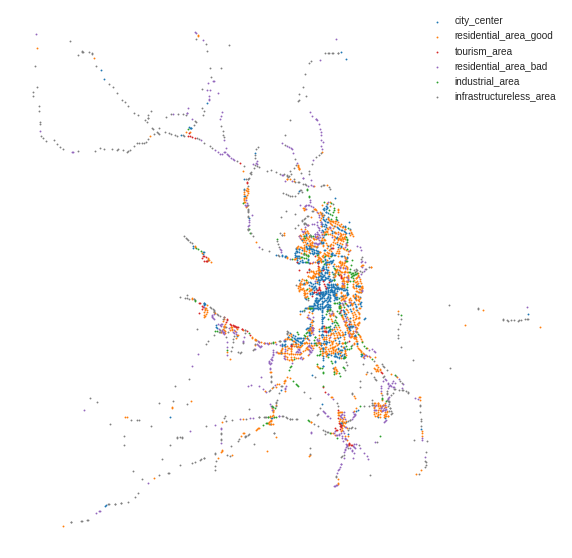

In [33]:
plt.figure(figsize=(10, 10))
plt.gca().axis('off')

for i in clusters['cluster'].unique():
    ids = clusters.loc[clusters['cluster'] == i, 'id']
    cluster_coords = supernodes.loc[ids, ['lon', 'lat']].values
    
    color = f'C{i}' if i != -1 else 'gray'
    
    plt.scatter(*cluster_coords.T, color=color, marker='.', s=3, label=named_clusters[i])
    
plt.legend()

In [37]:
clusters_json = [row.to_dict() for _, row in clusters.iterrows()]

clusters_json[:5]

[{'id': 0, 'cluster': 0, 'cluster_name': 'city_center'},
 {'id': 1, 'cluster': 0, 'cluster_name': 'city_center'},
 {'id': 2, 'cluster': 0, 'cluster_name': 'city_center'},
 {'id': 3, 'cluster': 1, 'cluster_name': 'residential_area_good'},
 {'id': 4, 'cluster': 0, 'cluster_name': 'city_center'}]

In [38]:
save_json(clusters_json, infrastructure_clusters_fpath)